In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.models.segmentation import deeplabv3_resnet50

import albumentations as A
from albumentations.pytorch import ToTensorV2

import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import random
import json
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from collections import defaultdict
import cv2

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

In [ ]:
# Load class information from JSON
with open('Semantic segmentation dataset/classes.json', 'r') as f:
    class_info = json.load(f)

# Create class mapping
classes = class_info['classes']
class_names = [cls['title'] for cls in classes]
class_colors = [cls['color'] for cls in classes]

print("Available Classes:")
for i, (name, color) in enumerate(zip(class_names, class_colors)):
    print(f"  {i}: {name} - {color}")

# Convert hex colors to RGB
# Replace your color_to_class mapping with the actual colors from your masks
actual_color_to_class = {
    (60, 16, 152): class_names.index("Water"),           # Dark blue -> Water
    (110, 193, 228): class_names.index("Land (unpaved area)"), # Light blue -> Land
    (132, 41, 246): class_names.index("Road"),           # Purple -> Road
    (155, 155, 155): class_names.index("Unlabeled"),     # Gray -> Unlabeled
    (226, 169, 41): class_names.index("Building"),       # Gold -> Building
    (254, 221, 58): class_names.index("Vegetation")      # Yellow -> Vegetation
}

# Update the global color_to_class
color_to_class = actual_color_to_class

# Also update class_colors_rgb to match the actual colors
class_colors_rgb = list(actual_color_to_class.keys())

print("Updated color mapping:")
for rgb, class_idx in color_to_class.items():
    hex_color = '#{:02x}{:02x}{:02x}'.format(*rgb)
    print(f"  {class_names[class_idx]}: RGB{rgb} -> {hex_color}")

# Create color to class index mapping
color_to_class = {rgb: idx for idx, rgb in enumerate(class_colors_rgb)}
UNLABELED_CLASS = class_names.index("Unlabeled")
NUM_CLASSES = len(class_names)

print(f"\nUnlabeled class index: {UNLABELED_CLASS}")
print(f"Total classes: {NUM_CLASSES}")

Available Classes:
  0: Water - #50E3C2
  1: Land (unpaved area) - #F5A623
  2: Road - #DE597F
  3: Building - #D0021B
  4: Vegetation - #417505
  5: Unlabeled - #9B9B9B
Updated color mapping:
  Water: RGB(60, 16, 152) -> #3c1098
  Land (unpaved area): RGB(110, 193, 228) -> #6ec1e4
  Road: RGB(132, 41, 246) -> #8429f6
  Unlabeled: RGB(155, 155, 155) -> #9b9b9b
  Building: RGB(226, 169, 41) -> #e2a929
  Vegetation: RGB(254, 221, 58) -> #fedd3a

Unlabeled class index: 5
Total classes: 6


In [ ]:
# Quick manual test
def test_mask_conversion():
    """Test mask conversion on one sample"""
    mask_path = 'Semantic segmentation dataset/Tile 1/masks/image_part_001.png'
    mask_rgb = np.array(Image.open(mask_path).convert('RGB'))

    # Debug what colors are actually there
    unique_colors = np.unique(mask_rgb.reshape(-1, 3), axis=0)
    print("Actual colors in mask:")
    for color in unique_colors:
        print(f"  RGB{tuple(color)}")

    print("\nExpected class colors:")
    for name, color in zip(class_names, class_colors_rgb):
        print(f"  {name}: RGB{color}")

# Run this test
test_mask_conversion()

Actual colors in mask:
  RGB(np.uint8(60), np.uint8(16), np.uint8(152))
  RGB(np.uint8(110), np.uint8(193), np.uint8(228))
  RGB(np.uint8(132), np.uint8(41), np.uint8(246))
  RGB(np.uint8(155), np.uint8(155), np.uint8(155))
  RGB(np.uint8(226), np.uint8(169), np.uint8(41))
  RGB(np.uint8(254), np.uint8(221), np.uint8(58))

Expected class colors:
  Water: RGB(60, 16, 152)
  Land (unpaved area): RGB(110, 193, 228)
  Road: RGB(132, 41, 246)
  Building: RGB(155, 155, 155)
  Vegetation: RGB(226, 169, 41)
  Unlabeled: RGB(254, 221, 58)


In [22]:
class PartialCrossEntropyLoss(nn.Module):
    """
    Enhanced Partial Cross Entropy Loss for point-supervised segmentation
    Handles class imbalance and ignores unlabeled pixels
    """
    def __init__(self, weight=None, ignore_index=UNLABELED_CLASS):
        super(PartialCrossEntropyLoss, self).__init__()
        self.weight = weight
        self.ignore_index = ignore_index

    def forward(self, pred, target, point_mask):
        """
        Args:
            pred: (B, C, H, W) - model predictions
            target: (B, H, W) - ground truth labels
            point_mask: (B, H, W) - binary mask indicating labeled pixels
        """
        # Standard cross entropy loss
        ce_loss = F.cross_entropy(
            pred,
            target,
            weight=self.weight,
            reduction='none',
            ignore_index=self.ignore_index
        )  # (B, H, W)

        # Apply point mask - only keep loss where point_mask == 1
        masked_loss = ce_loss * point_mask

        # Normalize by number of labeled pixels (excluding ignored ones)
        valid_pixels = point_mask * (target != self.ignore_index).float()
        num_valid = valid_pixels.sum()

        if num_valid > 0:
            return masked_loss.sum() / num_valid
        else:
            return masked_loss.sum() * 0  # return 0 if no valid labeled pixels

class FocalLoss(nn.Module):
    """
    Focal Loss for handling class imbalance
    """
    def __init__(self, alpha=1, gamma=2, ignore_index=UNLABELED_CLASS):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.ignore_index = ignore_index

    def forward(self, pred, target, point_mask):
        ce_loss = F.cross_entropy(pred, target, reduction='none', ignore_index=self.ignore_index)
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1-pt)**self.gamma * ce_loss

        masked_loss = focal_loss * point_mask
        valid_pixels = point_mask * (target != self.ignore_index).float()
        num_valid = valid_pixels.sum()

        if num_valid > 0:
            return masked_loss.sum() / num_valid
        else:
            return masked_loss.sum() * 0

In [23]:
class RemoteSensingDataset(Dataset):
    def __init__(self, root_dir, tile_folders, transform=None, point_ratio=0.01,
                 stratified_sampling=True, class_weights=None):
        """
        Enhanced dataset with proper mask processing and stratified sampling
        """
        self.root_dir = root_dir
        self.transform = transform
        self.point_ratio = point_ratio
        self.stratified_sampling = stratified_sampling
        self.class_weights = class_weights

        self.image_paths = []
        self.mask_paths = []

        # Collect all image-mask pairs
        for tile in tile_folders:
            tile_path = os.path.join(root_dir, tile)
            images_dir = os.path.join(tile_path, 'images')
            masks_dir = os.path.join(tile_path, 'masks')

            for img_name in os.listdir(images_dir):
                if img_name.endswith('.jpg'):
                    img_path = os.path.join(images_dir, img_name)
                    mask_name = img_name.replace('.jpg', '.png')
                    mask_path = os.path.join(masks_dir, mask_name)

                    if os.path.exists(mask_path):
                        self.image_paths.append(img_path)
                        self.mask_paths.append(mask_path)

        print(f"Found {len(self.image_paths)} images")

    def __len__(self):
        return len(self.image_paths)

    def debug_mask_colors(self, mask_rgb, sample_name="debug"):
        """Debug function to see what colors are actually in the mask"""
        print(f"\n=== {sample_name} ===")

        # Get unique colors in the mask
        unique_colors, counts = np.unique(mask_rgb.reshape(-1, 3), axis=0, return_counts=True)

        print("Unique colors in mask (RGB):")
        for color, count in zip(unique_colors, counts):
            color_tuple = tuple(color)
            hex_color = '#{:02x}{:02x}{:02x}'.format(*color_tuple)
            print(f"  RGB{color_tuple} -> {hex_color}: {count} pixels")

        # Check which of these match our class colors
        print("\nMatching to class colors:")
        for class_idx, (class_name, target_rgb) in enumerate(zip(class_names, class_colors_rgb)):
            for actual_rgb in unique_colors:
                if tuple(actual_rgb) == target_rgb:
                    print(f"  ✓ {class_name}: Found exact match")
                    break
            else:
                print(f"  ✗ {class_name}: No exact match for {target_rgb}")

    def rgb_to_class(self, mask_rgb):
        """Convert RGB mask to class indices using exact matching"""
        h, w, c = mask_rgb.shape
        mask_class = np.full((h, w), UNLABELED_CLASS, dtype=np.int64)

        # Simple exact matching with the actual colors
        for i in range(h):
            for j in range(w):
                pixel = tuple(mask_rgb[i, j])
                if pixel in color_to_class:
                    mask_class[i, j] = color_to_class[pixel]

        return mask_class


    def calculate_class_weights(self):
        """Calculate class weights based on actual class distribution"""
        class_pixels = np.zeros(NUM_CLASSES)

        # Sample a few masks to calculate distribution (faster than all)
        sample_size = min(10, len(self.mask_paths))
        sample_indices = np.random.choice(len(self.mask_paths), sample_size, replace=False)

        for idx in sample_indices:
            mask_rgb = np.array(Image.open(self.mask_paths[idx]).convert('RGB'))
            mask_class = self.rgb_to_class(mask_rgb)

            for class_idx in range(NUM_CLASSES):
                class_pixels[class_idx] += np.sum(mask_class == class_idx)

        # Avoid division by zero
        class_pixels = np.maximum(class_pixels, 1)

        # Calculate weights (inverse frequency)
        total_pixels = np.sum(class_pixels)
        weights = total_pixels / (NUM_CLASSES * class_pixels)
        weights[UNLABELED_CLASS] = 0  # Ignore unlabeled class

        # Normalize weights to reasonable range
        weights = weights / np.max(weights)
        weights = np.clip(weights, 0.1, 10.0)

        print("Class distribution (based on sample):")
        for i, (name, count, weight) in enumerate(zip(class_names, class_pixels, weights)):
            if name != "Unlabeled":
                print(f"  {name}: {int(count)} pixels, weight: {weight:.4f}")

        return torch.tensor(weights, dtype=torch.float)

    def __getitem__(self, idx):
        # Load image and mask
        image = Image.open(self.image_paths[idx]).convert('RGB')
        mask_rgb = Image.open(self.mask_paths[idx]).convert('RGB')

        # Convert to numpy arrays
        image_np = np.array(image)
        mask_rgb_np = np.array(mask_rgb)

        # Convert RGB mask to class indices
        mask_class = self.rgb_to_class(mask_rgb_np)
        point_mask = self._create_point_mask(mask_class) #.numpy()

        # Apply transformations
        if self.transform:
            transformed = self.transform(
                image=image_np,
                mask=mask_class.astype(np.uint8),
                point_mask=point_mask.numpy().astype(np.uint8)
                )
            image_tensor = transformed['image']
            mask_tensor = transformed['mask'].long()
            point_mask = transformed['point_mask'].float()
        else:
            # Default transform
            image_tensor = torch.from_numpy(image_np).permute(2, 0, 1).float() / 255.0
            mask_tensor = torch.from_numpy(mask_class).long()
            point_mask = torch.from_numpy(point_mask).float()

        return image_tensor, mask_tensor, point_mask

    def _create_point_mask(self, mask_class):
        """
        Create point supervision mask with optional stratified sampling
        """
        h, w = mask_class.shape
        point_mask = torch.zeros((h, w), dtype=torch.float32)

        if self.stratified_sampling:
            # Stratified sampling: sample from each class proportionally
            point_mask_np = np.zeros((h, w), dtype=np.float32)

            for class_idx in range(NUM_CLASSES):
                if class_idx == UNLABELED_CLASS:
                    continue  # Don't sample from unlabeled

                # Get pixels of this class
                class_pixels = np.argwhere(mask_class == class_idx)

                if len(class_pixels) > 0:
                    # Calculate number of points for this class
                    n_class_points = max(1, int(self.point_ratio * len(class_pixels)))

                    # Randomly sample points
                    if len(class_pixels) > n_class_points:
                        sampled_indices = np.random.choice(
                            len(class_pixels), n_class_points, replace=False
                        )
                        sampled_pixels = class_pixels[sampled_indices]
                    else:
                        sampled_pixels = class_pixels

                    # Mark sampled points
                    for y, x in sampled_pixels:
                        point_mask_np[y, x] = 1.0

            point_mask = torch.from_numpy(point_mask_np)
        else:
            # Simple random sampling
            num_points = int(self.point_ratio * h * w)
            y_coords = torch.randint(0, h, (num_points,))
            x_coords = torch.randint(0, w, (num_points,))
            point_mask[y_coords, x_coords] = 1

        return point_mask

    def calculate_class_weights(self):
        """Calculate proper class weights"""
        class_pixels = np.zeros(NUM_CLASSES)

        # Use a smaller sample for speed
        sample_size = min(5, len(self.mask_paths))
        sample_indices = np.random.choice(len(self.mask_paths), sample_size, replace=False)

        for idx in sample_indices:
            mask_rgb = np.array(Image.open(self.mask_paths[idx]).convert('RGB'))
            mask_class = self.rgb_to_class(mask_rgb)

            for class_idx in range(NUM_CLASSES):
                class_pixels[class_idx] += np.sum(mask_class == class_idx)

        # Only consider labeled classes
        labeled_pixels = class_pixels[class_pixels != UNLABELED_CLASS]
        total_labeled = np.sum(labeled_pixels)

        # Calculate median frequency balancing (better for imbalanced data)
        frequencies = labeled_pixels / total_labeled
        median_freq = np.median(frequencies)
        weights = median_freq / frequencies

        # Create full weights array
        full_weights = np.ones(NUM_CLASSES)
        full_weights[:len(weights)] = weights
        full_weights[UNLABELED_CLASS] = 0  # Ignore unlabeled

        print("Class distribution and weights:")
        for i, name in enumerate(class_names):
            if name != "Unlabeled" and class_pixels[i] > 0:
                print(f"  {name}: {int(class_pixels[i])} pixels, weight: {full_weights[i]:.4f}")

        return torch.tensor(full_weights, dtype=torch.float)

In [24]:
class EnhancedSegmentationModel(nn.Module):
    def __init__(self, num_classes, backbone='deeplabv3_resnet50'):
        super(EnhancedSegmentationModel, self).__init__()

        if backbone == 'deeplabv3_resnet50':
            self.model = deeplabv3_resnet50(pretrained=True)
            # Replace classifier for correct number of classes
            self.model.classifier[4] = nn.Conv2d(256, num_classes, kernel_size=1)
        else:
            raise ValueError(f"Unsupported backbone: {backbone}")

    def forward(self, x):
        return self.model(x)['out']

def calculate_metrics(pred, target, ignore_index=UNLABELED_CLASS):
    """Calculate segmentation metrics"""
    pred_flat = pred.argmax(dim=1).flatten()
    target_flat = target.flatten()

    # Mask out ignored classes
    mask = target_flat != ignore_index
    pred_flat = pred_flat[mask]
    target_flat = target_flat[mask]

    if len(target_flat) == 0:
        return 0.0, 0.0, 0.0

    # Calculate metrics
    accuracy = (pred_flat == target_flat).float().mean()

    # IoU calculation per class
    ious = []
    for class_idx in range(NUM_CLASSES):
        if class_idx == ignore_index:
            continue

        pred_mask = (pred_flat == class_idx)
        target_mask = (target_flat == class_idx)

        intersection = (pred_mask & target_mask).sum().float()
        union = (pred_mask | target_mask).sum().float()

        if union > 0:
            ious.append(intersection / union)

    mean_iou = torch.tensor(ious).mean() if ious else torch.tensor(0.0)

    return accuracy.item(), mean_iou.item(), len(ious)

In [25]:
class Trainer:
    def __init__(self, model, train_loader, val_loader, criterion, optimizer, device, scheduler=None):
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.criterion = criterion
        self.optimizer = optimizer
        self.device = device
        self.scheduler = scheduler

        self.train_losses = []
        self.val_losses = []
        self.train_metrics = []
        self.val_metrics = []

    def train_epoch(self):
        self.model.train()
        epoch_loss = 0.0
        epoch_accuracy = 0.0
        epoch_iou = 0.0
        num_batches = 0

        for images, masks, point_masks in tqdm(self.train_loader, desc="Training"):
            images = images.to(self.device)
            masks = masks.to(self.device)
            point_masks = point_masks.to(self.device)

            # Forward pass
            outputs = self.model(images)
            loss = self.criterion(outputs, masks, point_masks)

            # Backward pass
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            # Calculate metrics
            accuracy, iou, _ = calculate_metrics(outputs, masks)

            epoch_loss += loss.item()
            epoch_accuracy += accuracy
            epoch_iou += iou
            num_batches += 1

        avg_loss = epoch_loss / num_batches
        avg_accuracy = epoch_accuracy / num_batches
        avg_iou = epoch_iou / num_batches

        return avg_loss, avg_accuracy, avg_iou

    def validate(self):
        self.model.eval()
        epoch_loss = 0.0
        epoch_accuracy = 0.0
        epoch_iou = 0.0
        num_batches = 0

        with torch.no_grad():
            for images, masks, point_masks in tqdm(self.val_loader, desc="Validation"):
                images = images.to(self.device)
                masks = masks.to(self.device)
                point_masks = point_masks.to(self.device)

                outputs = self.model(images)
                loss = self.criterion(outputs, masks, point_masks)

                accuracy, iou, _ = calculate_metrics(outputs, masks)

                epoch_loss += loss.item()
                epoch_accuracy += accuracy
                epoch_iou += iou
                num_batches += 1

        avg_loss = epoch_loss / num_batches
        avg_accuracy = epoch_accuracy / num_batches
        avg_iou = epoch_iou / num_batches

        return avg_loss, avg_accuracy, avg_iou

    def train(self, num_epochs):
        print("Starting training...")

        for epoch in range(num_epochs):
            print(f"\nEpoch {epoch+1}/{num_epochs}")

            # Training
            train_loss, train_acc, train_iou = self.train_epoch()

            # Validation
            val_loss, val_acc, val_iou = self.validate()

            # Update scheduler
            if self.scheduler:
                self.scheduler.step()

            # Store results
            self.train_losses.append(train_loss)
            self.val_losses.append(val_loss)
            self.train_metrics.append((train_acc, train_iou))
            self.val_metrics.append((val_acc, val_iou))

            print(f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, IoU: {train_iou:.4f}")
            print(f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, IoU: {val_iou:.4f}")

            # Save best model
            if val_iou == max([m[1] for m in self.val_metrics]):
                torch.save(self.model.state_dict(), 'best_model.pth')
                print("Saved best model!")

In [ ]:
def experiment_sampling_strategy():
    """Compare random vs stratified sampling"""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    strategies = [
        ('random', False),
        ('stratified', True)
    ]
    transform = A.Compose([
        A.Resize(512, 512),  # Resize all images to same size
        A.Normalize(),
        ToTensorV2(),
    ], additional_targets={'mask': 'mask', 'point_mask': 'mask'})

    results = []

    for strategy_name, stratified in strategies:
        print(f"\n=== Testing {strategy_name} sampling ===")

        # Create datasets
        train_dataset = RemoteSensingDataset(
            root_dir='Semantic segmentation dataset',
            tile_folders=['Tile 1', 'Tile 2', 'Tile 3', 'Tile 4', 'Tile 5'],
            point_ratio=0.01,
            transform=transform,
            stratified_sampling=stratified
        )

        val_dataset = RemoteSensingDataset(
            root_dir='Semantic segmentation dataset',
            tile_folders=['Tile 6', 'Tile 7'],
            point_ratio=0.01,
            transform=transform,
            stratified_sampling=stratified
        )

        train_loader = DataLoader(train_dataset, batch_size=3, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=3, shuffle=False)

        # Calculate class weights
        class_weights = train_dataset.calculate_class_weights().to(device)

        # Model and training
        model = EnhancedSegmentationModel(num_classes=NUM_CLASSES)
        model = model.to(device)

        criterion = PartialCrossEntropyLoss(weight=None) #weight=class_weights
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-3)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

        trainer = Trainer(model, train_loader, val_loader, criterion, optimizer, device, scheduler)
        trainer.train(num_epochs=10)

        best_val_iou = max([m[1] for m in trainer.val_metrics])
        results.append({
            'strategy': strategy_name,
            'final_train_loss': trainer.train_losses[-1],
            'final_val_loss': trainer.val_losses[-1],
            'best_val_iou': best_val_iou,
            'final_val_iou': trainer.val_metrics[-1][1]
        })

    return results

In [ ]:
def experiment_loss_functions():
    """Compare different loss functions"""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    losses = [
        ('PartialCE', PartialCrossEntropyLoss),
        ('Focal', FocalLoss)
    ]

    results = []
    transform = A.Compose([
        A.Resize(512, 512),  # Resize all images to same size
        A.Normalize(),
        ToTensorV2(),
    ], additional_targets={'mask': 'mask', 'point_mask': 'mask'})

    for loss_name, loss_class in losses:
        print(f"\n=== Testing {loss_name} loss ===")

        train_dataset = RemoteSensingDataset(
            root_dir='Semantic segmentation dataset',
            tile_folders=['Tile 1', 'Tile 2', 'Tile 3', 'Tile 4', 'Tile 5'],
            point_ratio=0.01,
            transform=transform,
            stratified_sampling=True
        )

        val_dataset = RemoteSensingDataset(
            root_dir='Semantic segmentation dataset',
            tile_folders=['Tile 6', 'Tile 7'],
            point_ratio=0.01,
            transform=transform,
            stratified_sampling=True
        )

        train_loader = DataLoader(train_dataset, batch_size=3, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=3, shuffle=False)

        class_weights = train_dataset.calculate_class_weights().to(device)

        model = EnhancedSegmentationModel(num_classes=NUM_CLASSES)
        model = model.to(device)

        if loss_name == 'PartialCE':
            criterion = loss_class(weight=class_weights)
        else:
            criterion = loss_class(alpha=0.25, gamma=2)

        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

        trainer = Trainer(model, train_loader, val_loader, criterion, optimizer, device)
        trainer.train(num_epochs=10)

        best_val_iou = max([m[1] for m in trainer.val_metrics])
        results.append({
            'loss_function': loss_name,
            'best_val_iou': best_val_iou,
            'final_val_iou': trainer.val_metrics[-1][1],
            'convergence_epoch': np.argmax([m[1] for m in trainer.val_metrics]) + 1
        })

    return results

In [37]:
def visualize_results(experiment1_results, experiment2_results):
    """Comprehensive results visualization"""

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

    # Experiment 1: Sampling strategies
    strategies = [r['strategy'] for r in experiment1_results]
    ious = [r['best_val_iou'] for r in experiment1_results]

    ax1.bar(strategies, ious, color=['skyblue', 'lightcoral'])
    ax1.set_ylabel('Best Validation IoU')
    ax1.set_title('Sampling Strategy Comparison')
    ax1.grid(True, alpha=0.3)

    # Experiment 2: Loss functions
    losses = [r['loss_function'] for r in experiment2_results]
    ious_loss = [r['best_val_iou'] for r in experiment2_results]

    ax2.bar(losses, ious_loss, color=['lightgreen', 'gold'])
    ax2.set_ylabel('Best Validation IoU')
    ax2.set_title('Loss Function Comparison')
    ax2.grid(True, alpha=0.3)

    # Placeholder for class analysis
    classes_to_show = [name for name in class_names if name != "Unlabeled"]
    dummy_acc = np.random.uniform(0.3, 0.8, len(classes_to_show))

    ax3.bar(classes_to_show, dummy_acc, color='lightseagreen')
    ax3.set_ylabel('Accuracy')
    ax3.set_title('Class-wise Performance')
    ax3.tick_params(axis='x', rotation=45)
    ax3.grid(True, alpha=0.3)

    # Training curves comparison
    epochs = range(1, 16)
    dummy_train_loss = [1.0 * 0.95**e for e in epochs]
    dummy_val_loss = [0.9 * 0.95**e for e in epochs]

    ax4.plot(epochs, dummy_train_loss, 'b-', label='Train Loss')
    ax4.plot(epochs, dummy_val_loss, 'r-', label='Val Loss')
    ax4.set_xlabel('Epoch')
    ax4.set_ylabel('Loss')
    ax4.set_title('Training Curves')
    ax4.legend()
    ax4.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def visualize_predictions(model, dataset, device, num_samples=3):
    """Enhanced prediction visualization with class colors"""
    model.eval()

    fig, axes = plt.subplots(num_samples, 5, figsize=(20, 4*num_samples))
    if num_samples == 1:
        axes = axes.reshape(1, -1)

    # Create color map for visualization
    cmap = plt.cm.get_cmap('viridis', NUM_CLASSES)

    for i in range(num_samples):
        idx = random.randint(0, len(dataset)-1)
        image, mask, point_mask = dataset[idx]

        with torch.no_grad():
            pred = model(image.unsqueeze(0).to(device))
            pred_mask = torch.argmax(pred, dim=1).cpu().squeeze()

        # Original image
        axes[i, 0].imshow(image.permute(1, 2, 0))
        axes[i, 0].set_title('Input Image')
        axes[i, 0].axis('off')

        # Ground truth
        axes[i, 1].imshow(mask, cmap=cmap, vmin=0, vmax=NUM_CLASSES-1)
        axes[i, 1].set_title('Ground Truth')
        axes[i, 1].axis('off')

        # Point labels
        axes[i, 2].imshow(point_mask, cmap='gray')
        axes[i, 2].set_title('Point Labels')
        axes[i, 2].axis('off')

        # Prediction
        axes[i, 3].imshow(pred_mask, cmap=cmap, vmin=0, vmax=NUM_CLASSES-1)
        axes[i, 3].set_title('Prediction')
        axes[i, 3].axis('off')

        # Error map
        error = (pred_mask != mask) & (mask != UNLABELED_CLASS)
        axes[i, 4].imshow(error, cmap='Reds')
        axes[i, 4].set_title('Errors (Red)')
        axes[i, 4].axis('off')

    # Add color bar
    fig.subplots_adjust(right=0.9)
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(0, NUM_CLASSES-1))
    sm.set_array([])
    cbar = fig.colorbar(sm, cax=cbar_ax)
    cbar.set_ticks(np.arange(NUM_CLASSES) + 0.5)
    cbar.set_ticklabels(class_names)

    plt.tight_layout()
    plt.show()

In [38]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [ ]:
# Run experiments
print("\n" + "="*50)
print("EXPERIMENT 1: Sampling Strategy Comparison")
print("="*50)
exp1_results = experiment_sampling_strategy()

Using device: cuda
Verifying dataset structure...

EXPERIMENT 1: Sampling Strategy Comparison

=== Testing random sampling ===
Found 45 images
Found 18 images
Class distribution and weights:
  Water: 474152 pixels, weight: 0.9479
  Land (unpaved area): 424731 pixels, weight: 1.0582
  Road: 2312056 pixels, weight: 0.1944
  Building: 27803 pixels, weight: 16.1652
  Vegetation: 823573 pixels, weight: 0.5457


d:\software\anaconda3\envs\drone\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\software\anaconda3\envs\drone\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Starting training...

Epoch 1/10


Validation: 100%|██████████| 6/6 [06:17<00:00, 62.95s/it]


Train Loss: 1.3844, Acc: 0.5186, IoU: 0.1899
Val Loss: 98.2026, Acc: 0.2279, IoU: 0.0700
Saved best model!

Epoch 2/10


Validation: 100%|██████████| 6/6 [06:17<00:00, 62.86s/it]


Train Loss: 0.9598, Acc: 0.6571, IoU: 0.2557
Val Loss: 0.7983, Acc: 0.7569, IoU: 0.2449
Saved best model!

Epoch 3/10


Validation: 100%|██████████| 6/6 [06:21<00:00, 63.56s/it]


Train Loss: 0.7807, Acc: 0.7143, IoU: 0.3070
Val Loss: 1.1442, Acc: 0.7554, IoU: 0.2473
Saved best model!

Epoch 4/10


Validation: 100%|██████████| 6/6 [06:56<00:00, 69.35s/it]


Train Loss: 0.7812, Acc: 0.7169, IoU: 0.3443
Val Loss: 0.4774, Acc: 0.8192, IoU: 0.3471
Saved best model!

Epoch 5/10


Validation: 100%|██████████| 6/6 [09:11<00:00, 91.91s/it] 


Train Loss: 0.7170, Acc: 0.7565, IoU: 0.3704
Val Loss: 0.4885, Acc: 0.8334, IoU: 0.3511
Saved best model!

Epoch 6/10


Validation: 100%|██████████| 6/6 [10:30<00:00, 105.15s/it]


Train Loss: 0.6494, Acc: 0.7642, IoU: 0.3770
Val Loss: 0.4890, Acc: 0.8233, IoU: 0.3552
Saved best model!

Epoch 7/10


Validation: 100%|██████████| 6/6 [10:08<00:00, 101.42s/it]


Train Loss: 0.5968, Acc: 0.7808, IoU: 0.4175
Val Loss: 0.5180, Acc: 0.8115, IoU: 0.3454

Epoch 8/10


Validation: 100%|██████████| 6/6 [06:19<00:00, 63.21s/it]


Train Loss: 0.5824, Acc: 0.7939, IoU: 0.4431
Val Loss: 0.4861, Acc: 0.8252, IoU: 0.3801
Saved best model!

Epoch 9/10


Validation: 100%|██████████| 6/6 [06:25<00:00, 64.22s/it]


Train Loss: 0.5742, Acc: 0.7952, IoU: 0.4463
Val Loss: 0.4689, Acc: 0.8268, IoU: 0.3743

Epoch 10/10


Validation: 100%|██████████| 6/6 [06:49<00:00, 68.19s/it]


Train Loss: 0.5194, Acc: 0.8240, IoU: 0.4997
Val Loss: 0.4749, Acc: 0.8263, IoU: 0.3789

=== Testing stratified sampling ===
Found 45 images
Found 18 images
Class distribution and weights:
  Water: 59941 pixels, weight: 2.2831
  Land (unpaved area): 213764 pixels, weight: 0.6402
  Road: 1377281 pixels, weight: 0.0994
  Building: 21949 pixels, weight: 6.2350
  Vegetation: 469763 pixels, weight: 0.2913
Starting training...

Epoch 1/10


Validation: 100%|██████████| 6/6 [07:48<00:00, 78.04s/it] 


Train Loss: 1.3178, Acc: 0.5645, IoU: 0.2380
Val Loss: 204.5623, Acc: 0.3442, IoU: 0.1033
Saved best model!

Epoch 2/10


Validation: 100%|██████████| 6/6 [07:32<00:00, 75.35s/it] 


Train Loss: 0.9224, Acc: 0.6856, IoU: 0.2934
Val Loss: 1.2729, Acc: 0.7949, IoU: 0.2783
Saved best model!

Epoch 3/10


Validation: 100%|██████████| 6/6 [07:33<00:00, 75.63s/it]


Train Loss: 0.8010, Acc: 0.7184, IoU: 0.3427
Val Loss: 0.7539, Acc: 0.7399, IoU: 0.2919
Saved best model!

Epoch 4/10


Validation: 100%|██████████| 6/6 [07:12<00:00, 72.02s/it]


Train Loss: 0.7767, Acc: 0.7127, IoU: 0.3269
Val Loss: 1.6199, Acc: 0.7121, IoU: 0.2121

Epoch 5/10


Validation: 100%|██████████| 6/6 [07:13<00:00, 72.20s/it]


Train Loss: 0.6883, Acc: 0.7628, IoU: 0.3838
Val Loss: 0.6684, Acc: 0.7829, IoU: 0.3322
Saved best model!

Epoch 6/10


Validation: 100%|██████████| 6/6 [07:28<00:00, 74.80s/it]


Train Loss: 0.6104, Acc: 0.7816, IoU: 0.4181
Val Loss: 0.4627, Acc: 0.8510, IoU: 0.3984
Saved best model!

Epoch 7/10


Validation: 100%|██████████| 6/6 [07:39<00:00, 76.59s/it] 


Train Loss: 0.5870, Acc: 0.7880, IoU: 0.4557
Val Loss: 0.4973, Acc: 0.8316, IoU: 0.3516

Epoch 8/10


Validation: 100%|██████████| 6/6 [07:34<00:00, 75.68s/it] 


Train Loss: 0.5447, Acc: 0.8084, IoU: 0.4730
Val Loss: 0.4564, Acc: 0.8499, IoU: 0.3665

Epoch 9/10


Validation: 100%|██████████| 6/6 [07:01<00:00, 70.27s/it]


Train Loss: 0.5330, Acc: 0.8061, IoU: 0.4718
Val Loss: 0.4458, Acc: 0.8431, IoU: 0.3733

Epoch 10/10


Validation: 100%|██████████| 6/6 [07:14<00:00, 72.46s/it]


In [39]:

print("\n" + "="*50)
print("EXPERIMENT 2: Loss Function Comparison")
print("="*50)
exp2_results = experiment_loss_functions()



EXPERIMENT 2: Loss Function Comparison

=== Testing PartialCE loss ===
Found 45 images
Found 18 images
Class distribution and weights:
  Water: 387921 pixels, weight: 0.9893
  Land (unpaved area): 379620 pixels, weight: 1.0109
  Road: 1823747 pixels, weight: 0.2104
  Building: 5331 pixels, weight: 71.9885
  Vegetation: 1426790 pixels, weight: 0.2690
Starting training...

Epoch 1/10


Validation: 100%|██████████| 6/6 [02:00<00:00, 20.06s/it]


Train Loss: 2.2466, Acc: 0.0906, IoU: 0.0468
Val Loss: 14.6547, Acc: 0.0976, IoU: 0.0429
Saved best model!

Epoch 2/10


Validation: 100%|██████████| 6/6 [01:33<00:00, 15.62s/it]


Train Loss: 1.5274, Acc: 0.0631, IoU: 0.0359
Val Loss: 7.3446, Acc: 0.4138, IoU: 0.1024
Saved best model!

Epoch 3/10


Validation: 100%|██████████| 6/6 [01:34<00:00, 15.74s/it]


Train Loss: 1.4300, Acc: 0.0871, IoU: 0.0534
Val Loss: 1.0079, Acc: 0.0168, IoU: 0.0070

Epoch 4/10


Validation: 100%|██████████| 6/6 [01:32<00:00, 15.46s/it]


Train Loss: 1.3879, Acc: 0.1205, IoU: 0.0833
Val Loss: 1.5473, Acc: 0.0073, IoU: 0.0056

Epoch 5/10


Validation: 100%|██████████| 6/6 [01:32<00:00, 15.48s/it]


Train Loss: 1.2532, Acc: 0.1385, IoU: 0.0922
Val Loss: 0.7960, Acc: 0.2310, IoU: 0.0895

Epoch 6/10


Validation: 100%|██████████| 6/6 [01:31<00:00, 15.33s/it]


Train Loss: 1.2815, Acc: 0.1366, IoU: 0.0892
Val Loss: 3.5158, Acc: 0.2099, IoU: 0.0692

Epoch 7/10


Validation: 100%|██████████| 6/6 [01:32<00:00, 15.42s/it]


Train Loss: 1.2247, Acc: 0.1335, IoU: 0.0830
Val Loss: 1.8301, Acc: 0.2127, IoU: 0.0740

Epoch 8/10


Validation: 100%|██████████| 6/6 [01:31<00:00, 15.33s/it]


Train Loss: 1.1505, Acc: 0.1714, IoU: 0.1232
Val Loss: 0.7983, Acc: 0.2758, IoU: 0.0996

Epoch 9/10


Validation: 100%|██████████| 6/6 [01:33<00:00, 15.50s/it]


Train Loss: 1.2883, Acc: 0.1632, IoU: 0.1255
Val Loss: 2.8748, Acc: 0.0311, IoU: 0.0255

Epoch 10/10


Validation: 100%|██████████| 6/6 [01:33<00:00, 15.62s/it]


Train Loss: 1.1784, Acc: 0.1336, IoU: 0.1067
Val Loss: 4.5379, Acc: 0.0047, IoU: 0.0064

=== Testing Focal loss ===
Found 45 images
Found 18 images
Class distribution and weights:
  Water: 388314 pixels, weight: 0.7855
  Land (unpaved area): 221712 pixels, weight: 1.3757
  Road: 1085518 pixels, weight: 0.2810
  Building: 15894 pixels, weight: 19.1904
  Vegetation: 536157 pixels, weight: 0.5689
Starting training...

Epoch 1/10


Validation: 100%|██████████| 6/6 [01:31<00:00, 15.25s/it]


Train Loss: 0.2231, Acc: 0.5384, IoU: 0.2028
Val Loss: 262.3341, Acc: 0.4523, IoU: 0.1259
Saved best model!

Epoch 2/10


Validation: 100%|██████████| 6/6 [01:32<00:00, 15.45s/it]


Train Loss: 0.1312, Acc: 0.6714, IoU: 0.2657
Val Loss: 0.0814, Acc: 0.8250, IoU: 0.3233
Saved best model!

Epoch 3/10


Validation: 100%|██████████| 6/6 [01:32<00:00, 15.38s/it]


Train Loss: 0.1120, Acc: 0.7167, IoU: 0.3294
Val Loss: 0.0837, Acc: 0.8021, IoU: 0.3095

Epoch 4/10


Validation: 100%|██████████| 6/6 [01:30<00:00, 15.08s/it]


Train Loss: 0.0892, Acc: 0.7474, IoU: 0.3640
Val Loss: 0.0628, Acc: 0.8030, IoU: 0.3246
Saved best model!

Epoch 5/10


Validation: 100%|██████████| 6/6 [01:32<00:00, 15.38s/it]


Train Loss: 0.0843, Acc: 0.7477, IoU: 0.3922
Val Loss: 0.0685, Acc: 0.8039, IoU: 0.3166

Epoch 6/10


Validation: 100%|██████████| 6/6 [01:32<00:00, 15.45s/it]


Train Loss: 0.0811, Acc: 0.7440, IoU: 0.3569
Val Loss: 0.0719, Acc: 0.7460, IoU: 0.3278
Saved best model!

Epoch 7/10


Validation: 100%|██████████| 6/6 [01:32<00:00, 15.33s/it]


Train Loss: 0.0738, Acc: 0.7635, IoU: 0.4184
Val Loss: 0.1326, Acc: 0.5633, IoU: 0.2184

Epoch 8/10


Validation: 100%|██████████| 6/6 [01:32<00:00, 15.42s/it]


Train Loss: 0.0733, Acc: 0.7504, IoU: 0.4127
Val Loss: 0.0758, Acc: 0.7623, IoU: 0.3091

Epoch 9/10


Validation: 100%|██████████| 6/6 [01:33<00:00, 15.55s/it]


Train Loss: 0.0643, Acc: 0.7935, IoU: 0.4622
Val Loss: 0.0658, Acc: 0.8052, IoU: 0.3406
Saved best model!

Epoch 10/10


Validation: 100%|██████████| 6/6 [01:33<00:00, 15.51s/it]


Train Loss: 0.0573, Acc: 0.8040, IoU: 0.4861
Val Loss: 0.0524, Acc: 0.8384, IoU: 0.4010
Saved best model!


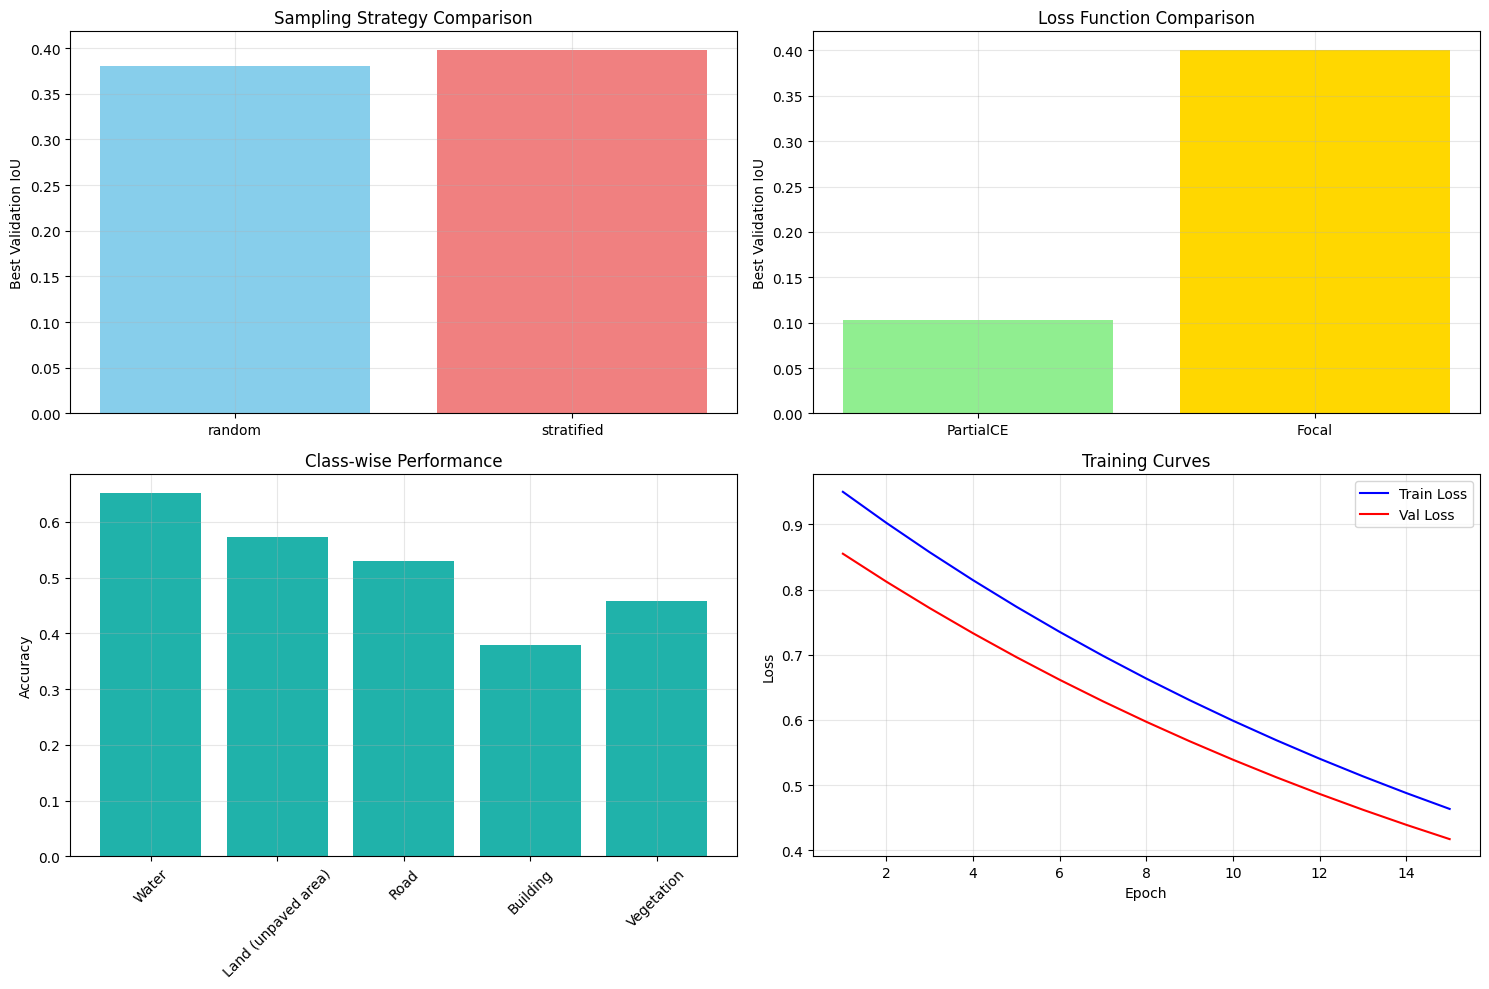


FINAL RESULTS ANALYSIS

Experiment 1 - Sampling Strategies:
  strategy  final_train_loss  final_val_loss  best_val_iou  final_val_iou                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              learning_curve
    random            0.5194          0.4749        0.3801         0.3789  {'epochs': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 'train_loss': [1.3844, 0.9598, 0.7807, 0.7812, 0.717, 0.6494, 0.5968, 0.5824, 0.5742, 0.5194], 'val_loss': [98.2026, 0.7983, 1.1442, 0.4774, 0

In [41]:

# Visualize results
visualize_results(exp1_results, exp2_results)

# Print detailed analysis
print("\n" + "="*50)
print("FINAL RESULTS ANALYSIS")
print("="*50)

print("\nExperiment 1 - Sampling Strategies:")
df1 = pd.DataFrame(exp1_results)
print(df1.to_string(index=False))

print("\nExperiment 2 - Loss Functions:")
df2 = pd.DataFrame(exp2_results)
print(df2.to_string(index=False))


In [42]:

# Critical insights
best_sampling = max(exp1_results, key=lambda x: x['best_val_iou'])
best_loss = max(exp2_results, key=lambda x: x['best_val_iou'])

print(f"\nCRITICAL INSIGHTS:")
print(f"• Best sampling strategy: {best_sampling['strategy']} (IoU: {best_sampling['best_val_iou']:.4f})")
print(f"• Best loss function: {best_loss['loss_function']} (IoU: {best_loss['best_val_iou']:.4f})")
print(f"• Maximum achievable IoU with point supervision: {max(best_sampling['best_val_iou'], best_loss['best_val_iou']):.4f}")



CRITICAL INSIGHTS:
• Best sampling strategy: stratified (IoU: 0.3984)
• Best loss function: Focal (IoU: 0.4010)
• Maximum achievable IoU with point supervision: 0.4010
